Для работы выбрал датасет "данные об осадках".

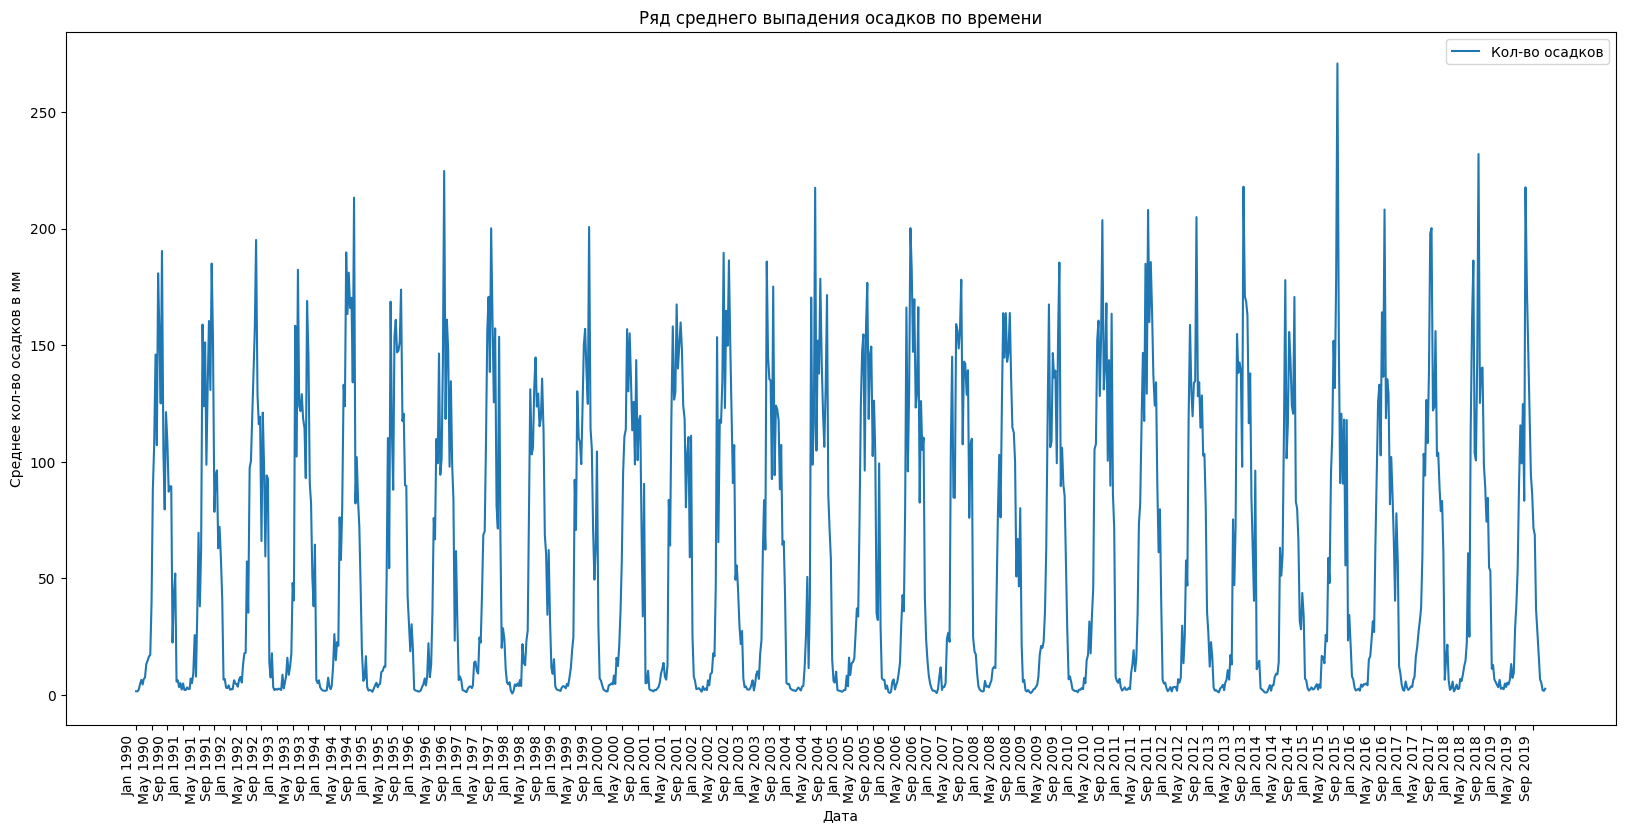

In [148]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('rainfall.csv')


df['date'] = pd.to_datetime(df['date'])


df.set_index('date', inplace=True)

plt.figure(figsize=(20, 9))
plt.plot(df['mean_rainfall'], label='Кол-во осадков')
plt.title('Ряд среднего выпадения осадков по времени')
plt.xlabel('Дата')
plt.ylabel('Среднее кол-во осадков в мм')
plt.legend()

#Добавил месяцы на ось X. Раз в 5 месяцев для лучшего восприятия и понимания графика
plt.xticks(df.index[::12], [date.strftime('%b %Y') for date in df.index[::12]], rotation=90, ha='right')
plt.show()
#Предположения о тренде, сезонности, стационарности.
#Тренд: В локальной картине, ограниченной рамками одного года, можно заметить, что зимой
#осадки почти что равны 0.
#После чего идет подъем числа осадков, где локальный максимум приходится примерно на май,
#затем идет постепенный спад с локальным минимумов в январе.
#В глобальной же картине можно сделать вывод, что тренд плоский.
#Сезонность: На графике присутствует сезонность.
#Она выражается циклическим изменением графика: от низкого количества осадков в зимние месяцы
#до высокого в летние. И т.д.
#Стационарность: Если присутствует выраженная сезонность => ряд не может быть стационарным.

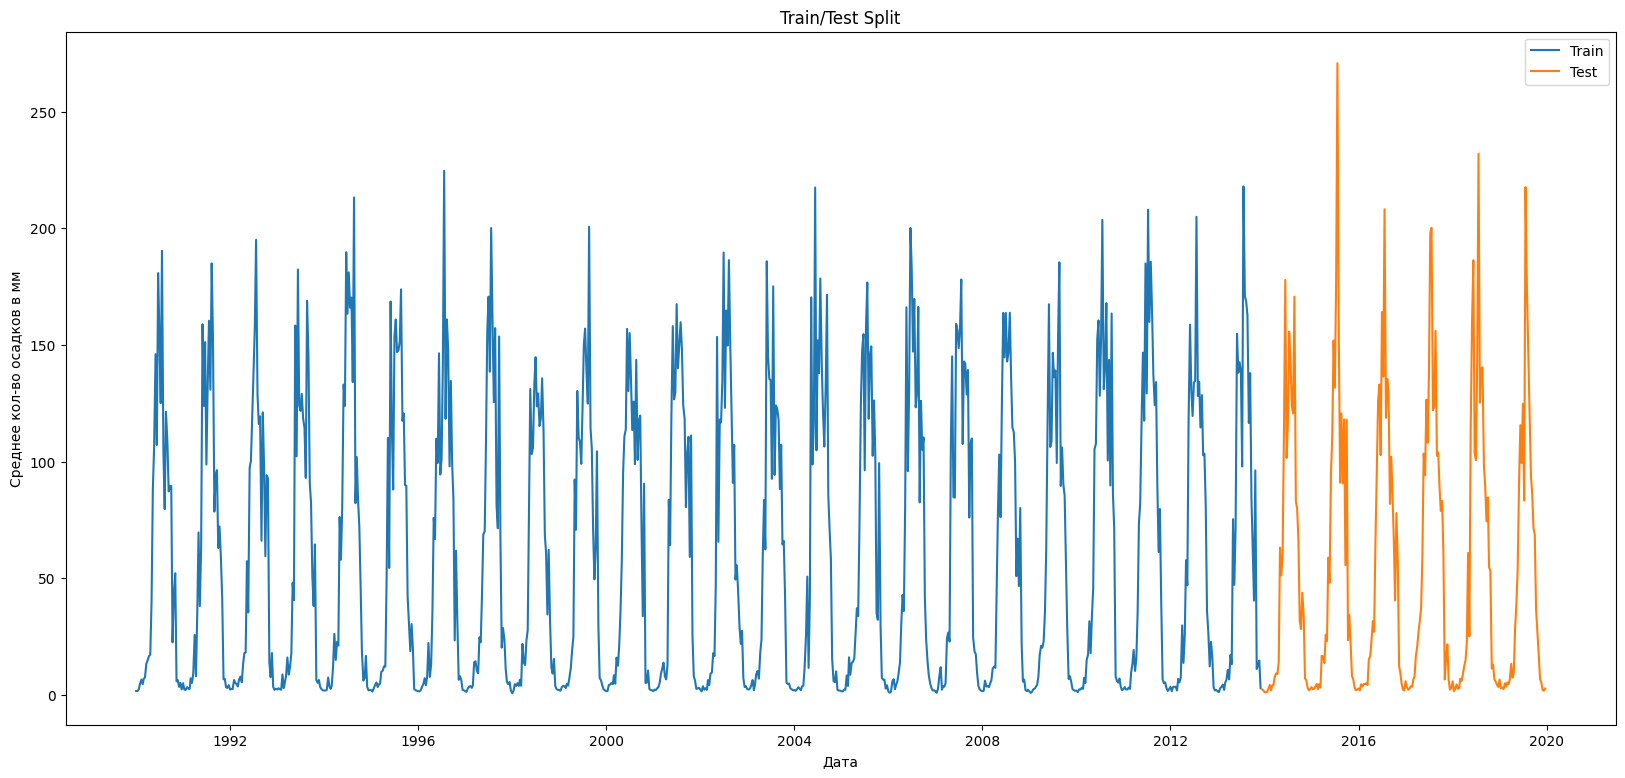

In [149]:
from sklearn.model_selection import train_test_split
y = df['mean_rainfall']
# Разделение данных на обучающую и тестовую выборки
train_size = 0.8
train, test = train_test_split(df, test_size=1 - train_size, shuffle=False)

# Визуализация разделения
plt.figure(figsize=(20, 9))
plt.plot(train['mean_rainfall'], label='Train')
plt.plot(test['mean_rainfall'], label='Test')
plt.title('Train/Test Split')
plt.xlabel('Дата')
plt.ylabel('Среднее кол-во осадков в мм')
plt.legend()
plt.show()

**Бейзлайн**

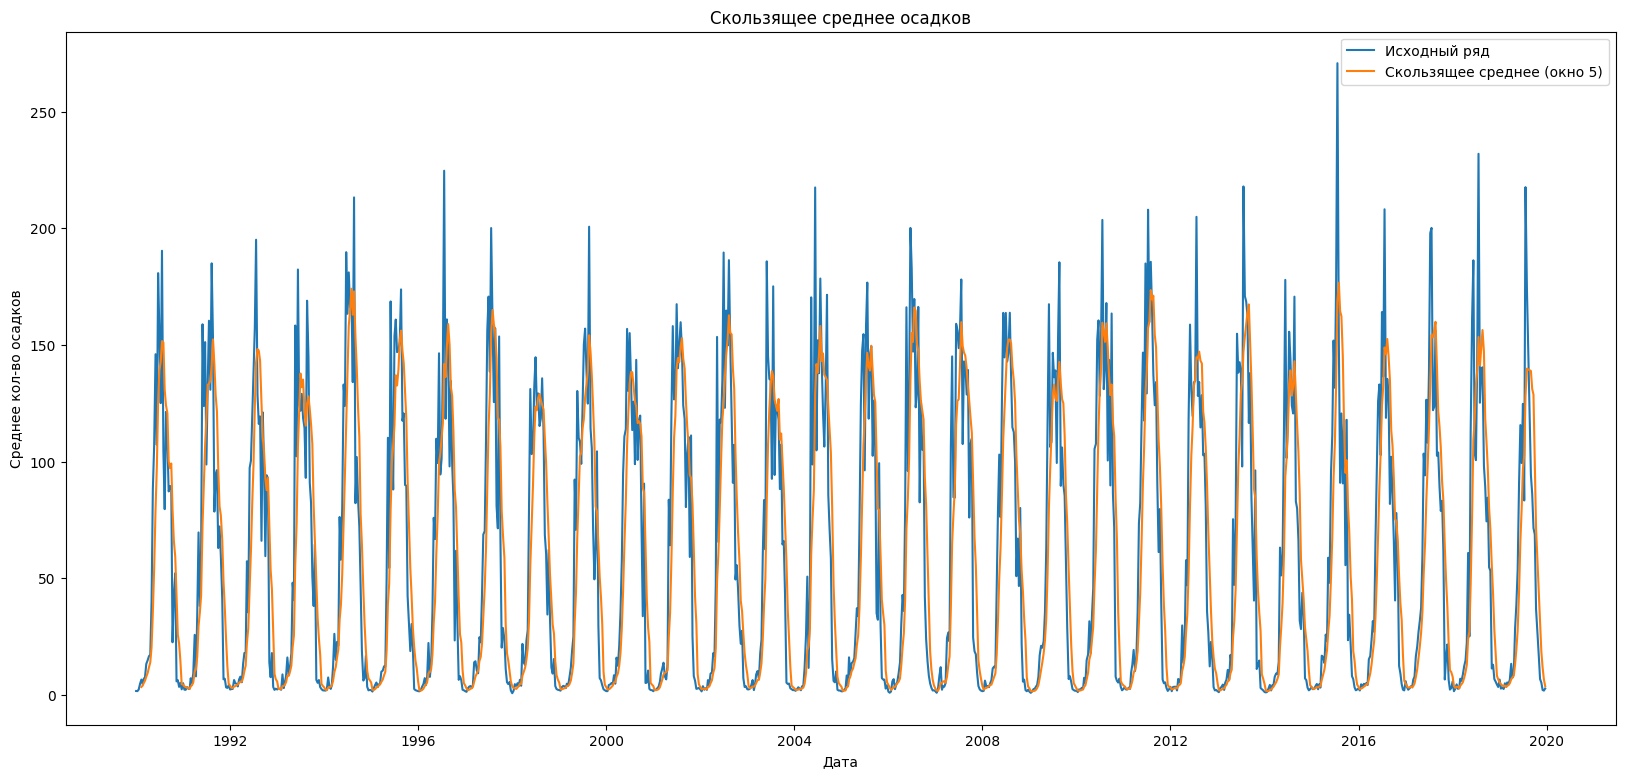

Mean Absolute Error для скользящего среднего: 19.457326629422717


In [150]:
from sklearn.metrics import mean_absolute_error

#Скользящее среднее
window_size = 5
rolling_mean_forecast = df['mean_rainfall'].rolling(window=window_size).mean()

# Визуализация результатов
plt.figure(figsize=(20, 9))
plt.plot(df['mean_rainfall'], label='Исходный ряд')
plt.plot(rolling_mean_forecast, label=f'Скользящее среднее (окно {window_size})')
plt.title('Скользящее среднее осадков')
plt.xlabel('Дата')
plt.ylabel('Среднее кол-во осадков')
plt.legend()
plt.show()

# Вычисление MAE для скользящего среднего
mae_rolling_mean = mean_absolute_error(df['mean_rainfall'][window_size-1:], rolling_mean_forecast.dropna().values)

# Вывод метрики MAE
print(f'Mean Absolute Error для скользящего среднего: {mae_rolling_mean}')


**Статистическая модель**

In [151]:
from statsmodels.tsa.stattools import adfuller

# Проведение теста Дики-Фуллера
result = adfuller(df['mean_rainfall'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# Интерпретация результатов
if result[1] <= 0.05:
    print("Ряд стационарный.")
else:
    print("Ряд нестационарный.")
#Ряд получился стационарным. Хотя до этого в первом пункте указал,
#что он не является стационарным. Доверюсь расчетам, а не визуальному предположению.

ADF Statistic: -17.09253438246042
p-value: 7.573294206434818e-30
Critical Values: {'1%': -3.4365635376940706, '5%': -2.86428345899922, '10%': -2.5682307228049686}
Ряд стационарный.


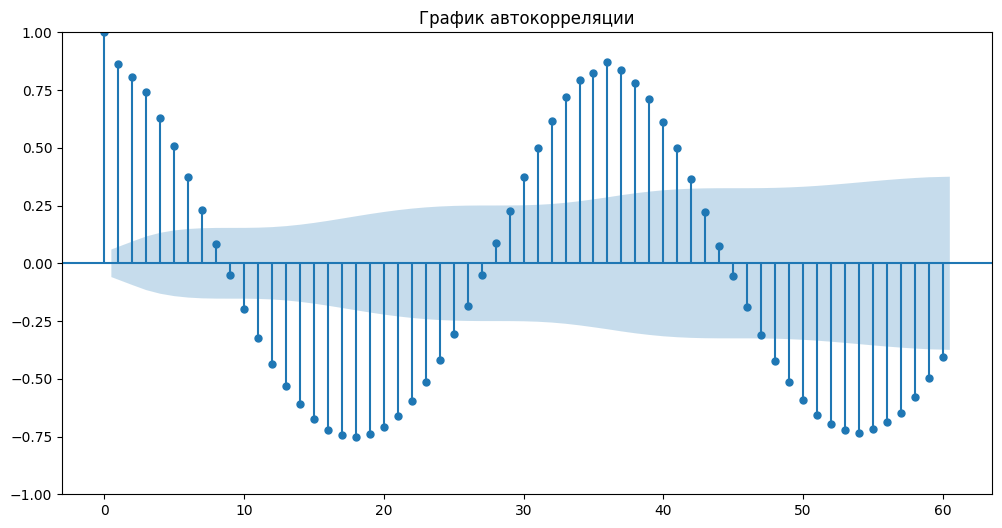

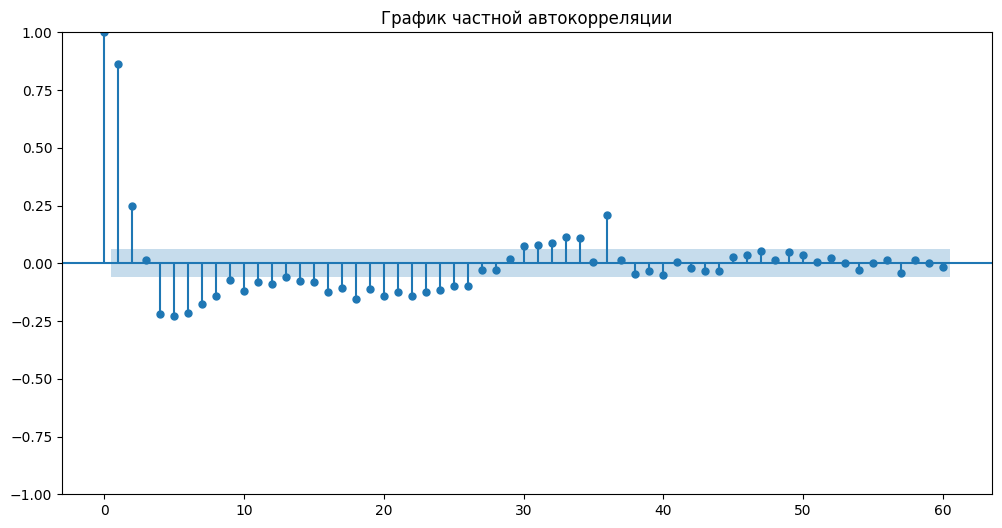

In [152]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# График автокорреляции
plt.figure(figsize=(12, 6))
plot_acf(df['mean_rainfall'], lags=60, ax=plt.gca())
plt.title('График автокорреляции')
plt.show()

# График частной автокорреляции
plt.figure(figsize=(12, 6))
plot_pacf(df['mean_rainfall'], lags=60, ax=plt.gca())
plt.title('График частной автокорреляции')
plt.show()

#По графикам можно сделать вывод, что на них есть сезонность.

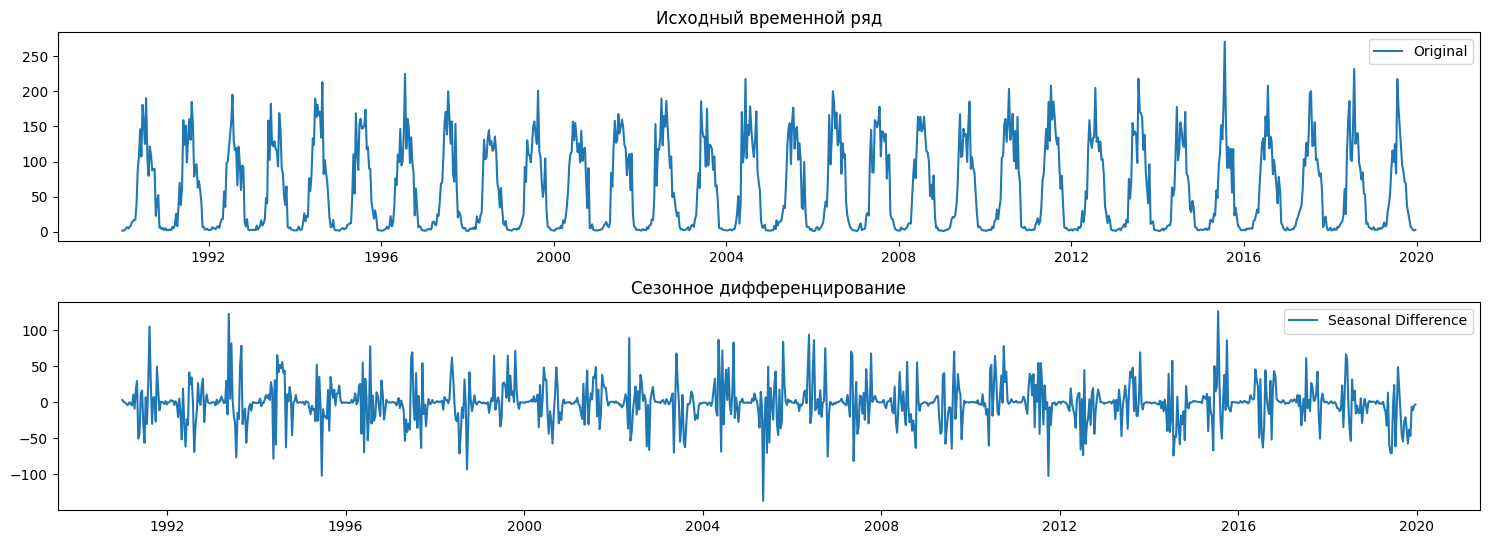

In [153]:
#Сезонное дифференцирование
df['diff_seasonal'] = df['mean_rainfall'].diff(36)


plt.figure(figsize=(15, 8))


plt.subplot(311)
plt.plot(df['mean_rainfall'], label='Original')
plt.title('Исходный временной ряд')
plt.legend()


plt.subplot(312)
plt.plot(df['diff_seasonal'], label='Seasonal Difference')
plt.title('Сезонное дифференцирование')
plt.legend()

plt.tight_layout()
plt.show()


ADF Statistic: -17.294242198923907
p-value: 5.6799236716833946e-30
Critical Values: {'1%': -3.436659460539809, '5%': -2.864325767240336, '10%': -2.5682532565554537}


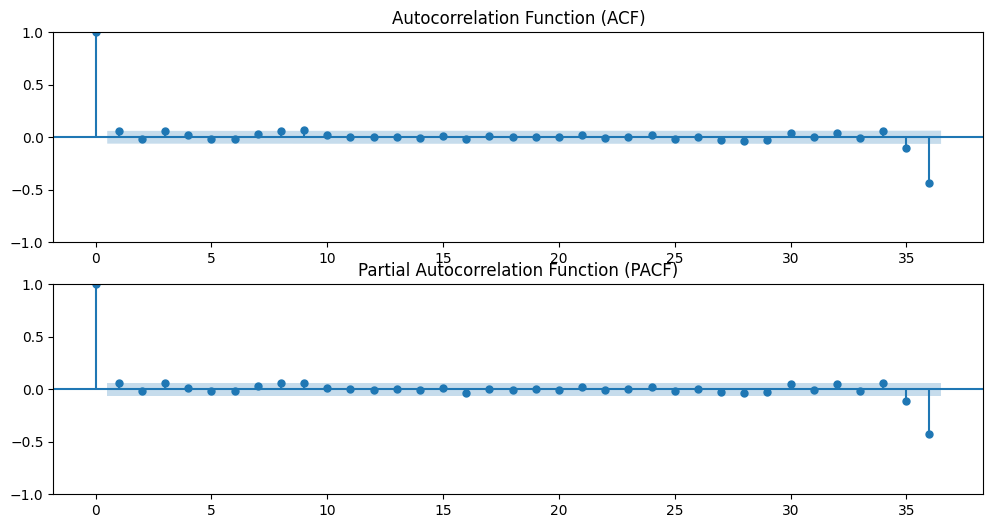

Ряд стационарен.


In [154]:
#Функция для теста Дики-Фуллера и визуализации ACF/PACF
def check_stationarity(data, column_name, lags=36):
    #Тест Дики-Фуллера
    result = adfuller(data[column_name].dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values: {result[4]}')

    #Визуализация ACF/PACF
    plt.figure(figsize=(12, 6))
    plt.subplot(211)
    plot_acf(data[column_name].dropna(), ax=plt.gca(), lags=lags)
    plt.title('Autocorrelation Function (ACF)')
    plt.subplot(212)
    plot_pacf(data[column_name].dropna(), ax=plt.gca(), lags=lags)
    plt.title('Partial Autocorrelation Function (PACF)')
    plt.show()

#Тест Дики-Фуллера и визуализация ACF/PACF для первого дифференцирования
check_stationarity(df, 'diff_seasonal')
if result[1] <= 0.05:
    print("Ряд стационарен.")
else:
    print("Ряд нестационарен.")


**По результатам дифференцирования можно сделать вывод, что удалось почти полностью избавиться от сезонности. Но, небольшие "шумы" присутствуют.**

In [155]:
pip install pmdarima

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=10032.843, Time=2.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=11899.031, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=10433.152, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=11195.708, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12617.868, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=10346.270, Time=0.97 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=10367.611, Time=1.65 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=10035.196, Time=7.02 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=10035.942, Time=7.21 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=10376.548, Time=1.42 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=10288.001, Time=4.40 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=10362.380, Time=5.38 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=8.70 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=10264.216, Time=1.14 sec

Best model:  ARIMA(2,0,2

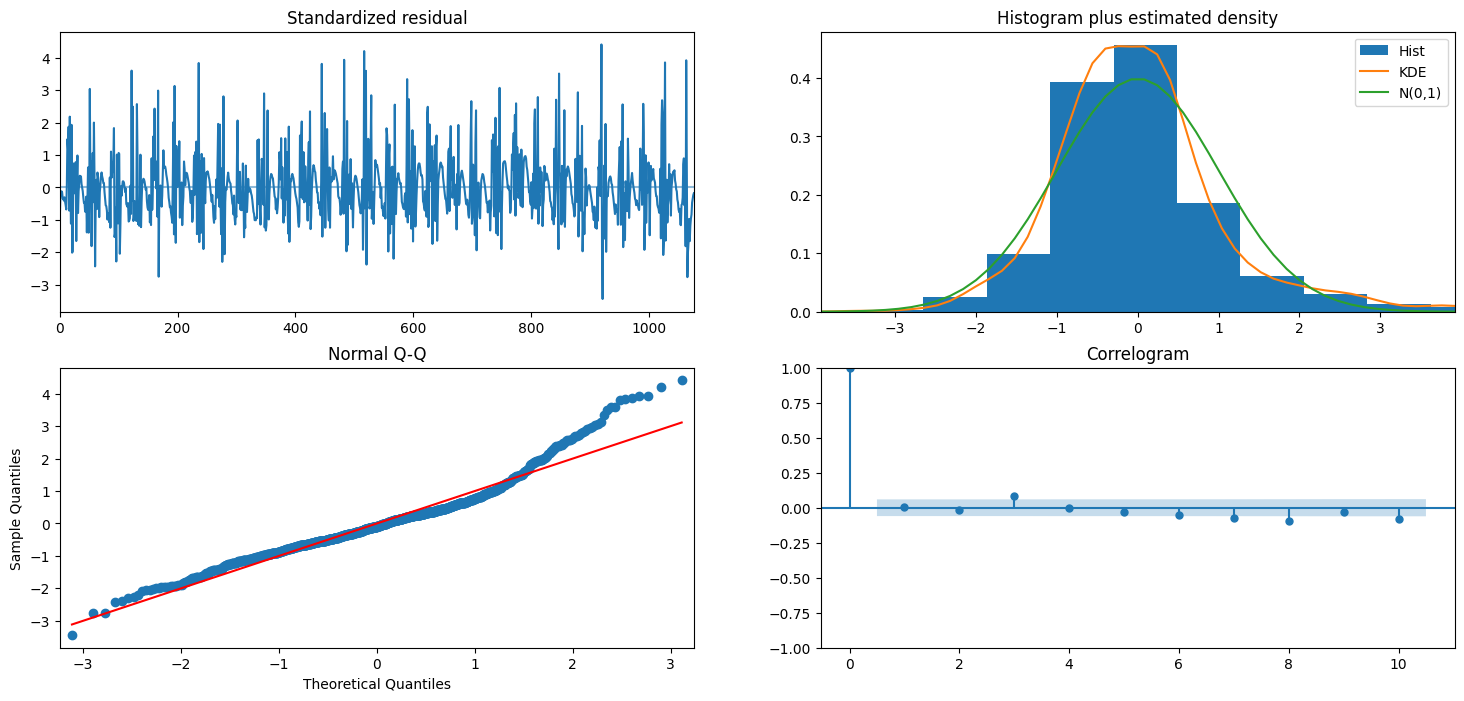

No supported index is available. Prediction results will be given with an integer index beginning at `start`.
No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.


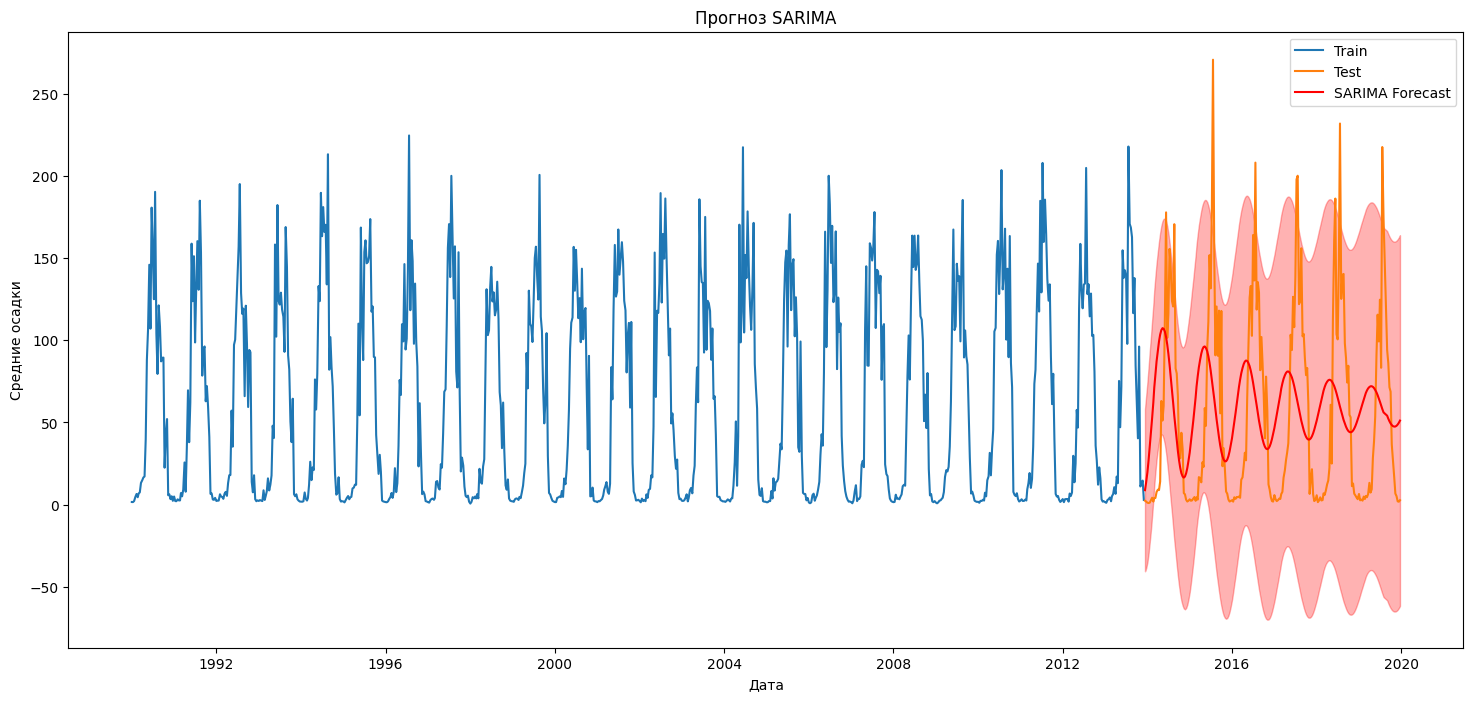

Среднеквадратичная ошибка для прогноза SARIMA: 3403.4428700007297


In [156]:
import pmdarima as pm
from sklearn.metrics import mean_squared_error
#Обучение SARIMA модели и подбор параметров
model = pm.auto_arima(df['mean_rainfall'], seasonal=True, stepwise=True, suppress_warnings=True, trace=True)

#Визуализация результатов
model.plot_diagnostics(figsize=(18, 8))
plt.show()

#Прогнозирование на тестовом периоде
forecast, conf_int = model.predict(n_periods=len(test), return_conf_int=True)

#Визуализация результатов прогноза
plt.figure(figsize=(18, 8))
plt.plot(train.index, train['mean_rainfall'], label='Train')
plt.plot(test.index, test['mean_rainfall'], label='Test')
plt.plot(test.index, forecast, label='SARIMA Forecast', color='red')
plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='red', alpha=0.3)
plt.xlabel('Дата')
plt.ylabel('Средние осадки')
plt.title('Прогноз SARIMA')
plt.legend()
plt.show()

#Замеры качества модели
sarima_mse = mean_squared_error(test['mean_rainfall'], forecast)
print(f'Среднеквадратичная ошибка для прогноза SARIMA: {sarima_mse}')

MSE для бейзлайна ~ 19, для SARIMA = 3403. Значительная разница. С чем может быть связана - не знаю.

**Классическая модель**

In [157]:
#Создание лагов
lags = range(1, 37)
for lag in lags:
    df[f'mean_rainfall_lag_{lag}'] = df['mean_rainfall'].shift(lag)

#Создание скользящих статистик
windows = [3, 5, 7]
for window in windows:
    df[f'mean_rainfall_mean_{window}'] = df['mean_rainfall'].rolling(window=window).mean()
    df[f'mean_rainfall_std_{window}'] = df['mean_rainfall'].rolling(window=window).std()

#Создание признаков из даты
df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday

#Удаление строк с пропущенными значениями
df.dropna(inplace=True)

train = df[df.index < '2019-12-01']
test = df[df.index >= '2019-12-01']


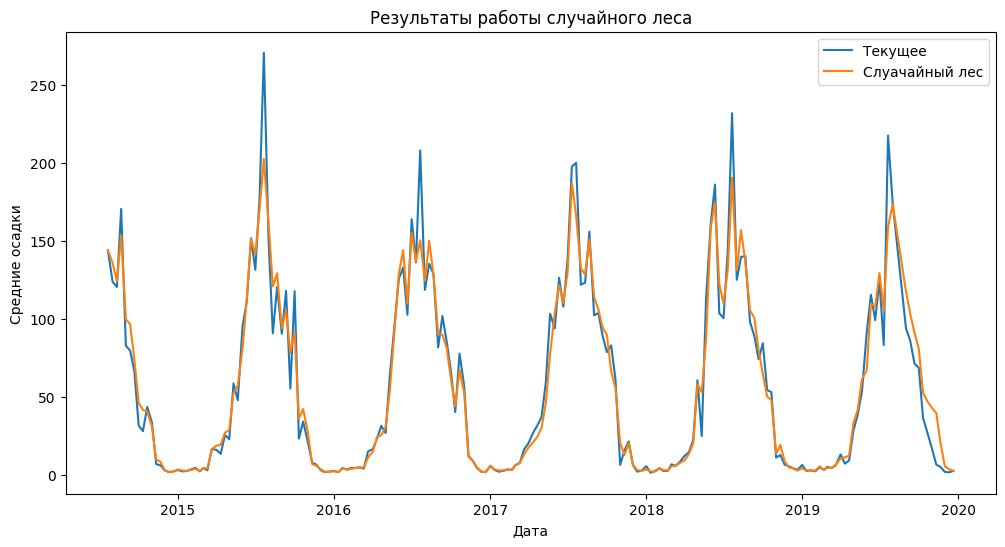

Среднеквадратичная ошибка (MSE) для Random Forest: 160.60644671541664


In [165]:
#Добавление лагов в данные
lags = range(1, 37)
for lag in lags:
    df[f'mean_rainfall_lag_{lag}'] = df['mean_rainfall'].shift(lag)

df.dropna(inplace=True)

#Разделение на train и test
train_size = int(0.8 * len(df))
train, test = df[:train_size], df[train_size:]

#Создание матрицы признаков и вектора ответов
X_train, y_train = train.drop('mean_rainfall', axis=1), train['mean_rainfall']
X_test, y_test = test.drop('mean_rainfall', axis=1), test['mean_rainfall']

#Обучение леса
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

#Прогноз на тестовом наборе
rf_predictions = rf_model.predict(X_test)

#Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['mean_rainfall'], label='Текущее')
plt.plot(test.index, rf_predictions, label='Случайный лес')
plt.xlabel('Дата')
plt.ylabel('Средние осадки')
plt.legend()
plt.title('Результаты работы случайного леса')
plt.show()

#Оценка качества случайного леса
rf_mse = mean_squared_error(test['mean_rainfall'], rf_predictions)
print(f'Среднеквадратичная ошибка (MSE) для Random Forest: {rf_mse}')


В результате выполнения кода можно заметить, что MSE уменьшилась. Таким образом случайный лес предпочтительнее SARIMA

**Интерпретация**

*Permutation importance*

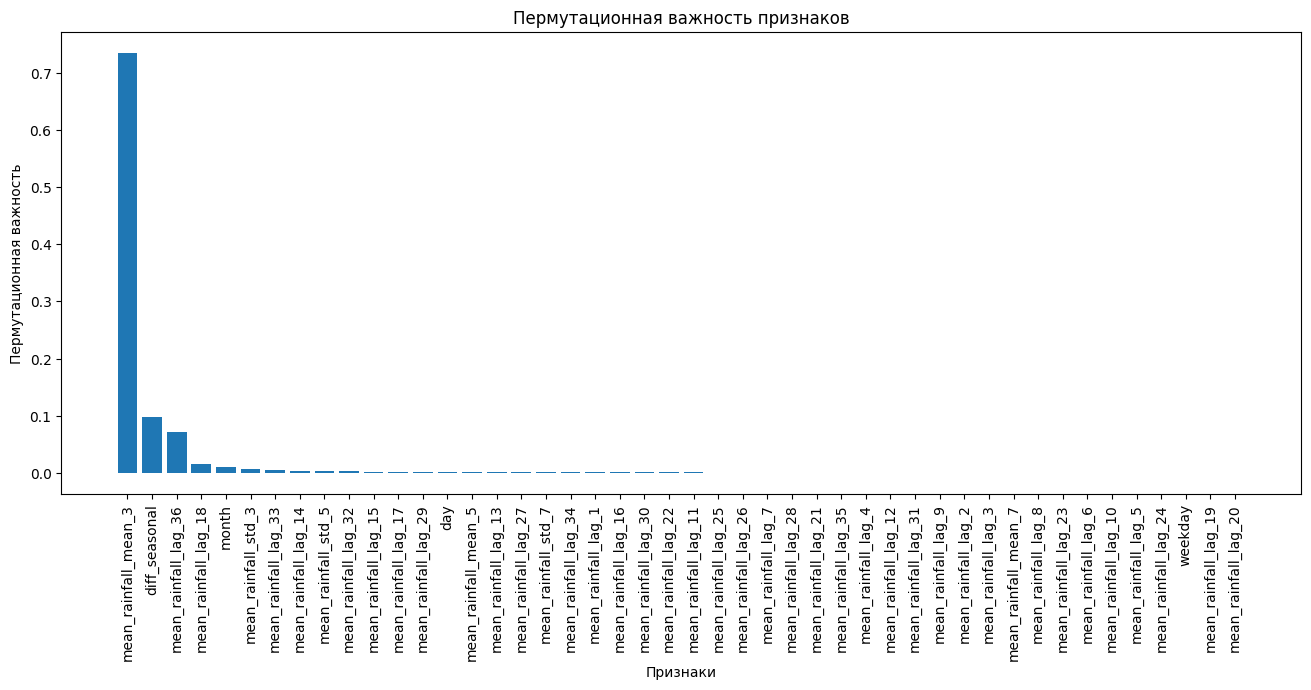

In [159]:
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

#Вычисление начальной метрики
initial_mse = mean_squared_error(test['mean_rainfall'], rf_predictions)

#Вычисление permutation importance
perm_importance = permutation_importance(rf_model, X_test, y_test, n_repeats=30, random_state=42)

#Визуализация результатов
sorted_idx = perm_importance.importances_mean.argsort()[::-1]
features = X_test.columns
plt.figure(figsize=(16, 6))
plt.bar(range(X_test.shape[1]), perm_importance.importances_mean[sorted_idx])
plt.xticks(range(X_test.shape[1]), features[sorted_idx], rotation=90)
plt.xlabel('Признаки')
plt.ylabel('Пермутационная важность')
plt.title('Пермутационная важность признаков')
plt.show()

По данному графику можно заметить пермутационную важность каждого из признаков

*Lime*

In [160]:
!pip install lime

In [164]:
import lime

def predict_proba(X):
    predictions = rf_model.predict(X)
    return predictions

#LIME Explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                   feature_names=list(X_train.columns),
                                                   class_names=['mean_rainfall'],
                                                   mode='regression', random_state=30)

#Выбор объекта для интерпретации
instance_to_interpret = X_test.iloc[0]

#Интерпретация для объекта
lime_exp = explainer.explain_instance(instance_to_interpret, predict_proba, num_features=len(X_test.columns))
lime_exp.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


Здесь также отображается важность каждого признака. Видим, что mean_rainfall_mean_3 имеет наибольший вес

*SHAP Local*

In [162]:
!pip install shap
import shap

#Инициализация SHAP
shap.initjs()

#Инициализация SHAP Explainer
shap_explainer = shap.TreeExplainer(rf_model)

#Вычисление SHAP значений для конкретного объекта
shap_values = shap_explainer.shap_values(instance_to_interpret)

#Визуализация SHAP значений для объекта
shap.force_plot(shap_explainer.expected_value, shap_values, feature_names=list(X_test.columns))

Визуализация SHAP строит график силы. Он показывает вклад каждого признака в отклонение предсказанного значения от среднего предсказания модели.

*SHAP Global*

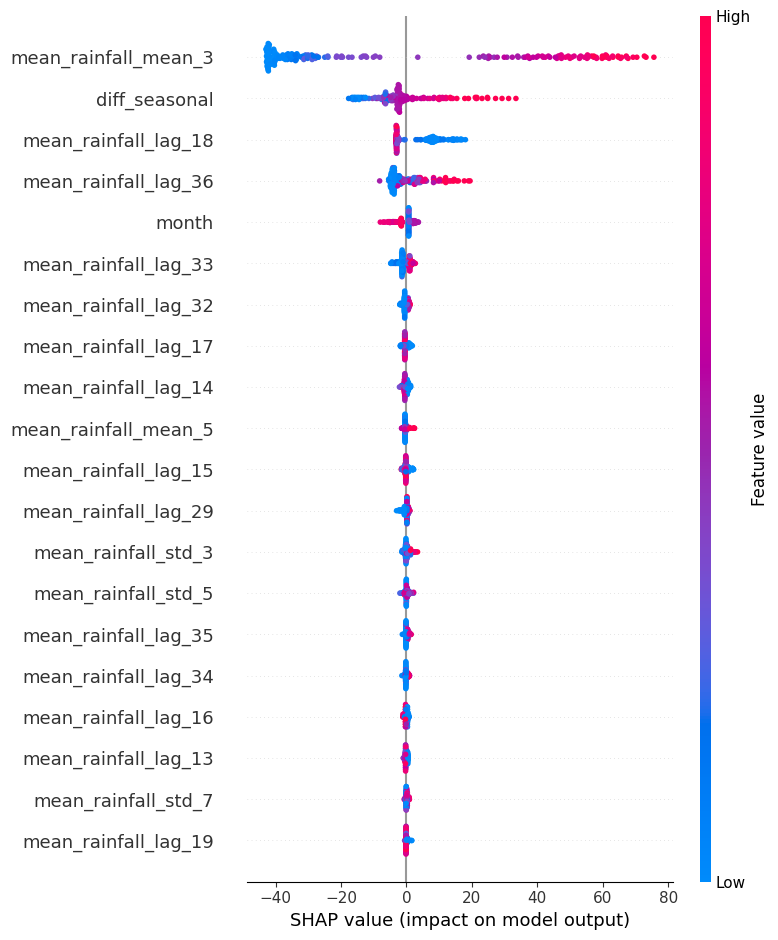

In [163]:
#Вычисление SHAP значений для всего тестового набора
shap_values_all = shap_explainer.shap_values(X_test)

#Визуализация summary plot
shap.summary_plot(shap_values_all, X_test)

Здесь можно заметить признаки, которые проявляют наибольшую силу по сравнению с другими. Это mean_rainfall_mean_3, diff_seasonal, mean_rainfall_lag_18, mean_rainfall_lag_36, mean_rainfall_lag_13, mean_rainfall_std_3.

Из всех интерпретаций моделей, на мой взгляд, наиболее удобная - lime. Она отображает положительные и отрицательные признаки. Положительные увеличивают предсказанное значение целевой переменной, отрицательные, наоборот, уменьшают.